In [1]:
import sys
import shapely
from shapely.geometry import box, MultiPolygon, LineString, Point, MultiLineString, Polygon
import math
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from gridmap import OccupancyGridMap
import matplotlib.pyplot as plt
from a_star import a_star
from utils import plot_path
from sklearn import preprocessing
import pandas as pd
from tqdm import tqdm

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_val_score, train_test_split
import random
from tqdm import tqdm
import imageio

import warnings
warnings.filterwarnings('ignore')

In [2]:
num_points_on_circ = 8
pi = math.pi
def PointsInCircum(r,n=num_points_on_circ, center = (0,0)):
    return np.array([(center[0] + math.cos(2*pi/n*x)*r, center[1] + math.sin(2*pi/n*x)*r) for x in range(0,n+1)])

In [3]:
def gen_shapely_map(map_size, obstacles):
    '''
    Given map_size and list of obstacles where
    an obstacle is described by a tuple (xmin, ymin, xmax, ymax),
    create a shapely map. 
    '''
    
    pols = [box(0,0,map_size[0], map_size[1])]
    for obstacle in obstacles:
        pols.append(box(*obstacle))
    lines = []
    for pol in pols:
        boundary = pol.boundary
        if boundary.type == 'MultiLineString':
            for line in boundary:
                lines.append(line)
        else:
            lines.append(boundary)

    MAP = MultiLineString(lines)
    return MAP

def get_map_arr(MAP_params, shape):
    '''
    Convert the shapely obstacles into a numpy grid
    for use with the A* planner. 
    
    MAP_params is of the form [(xmin, ymin, xmax, ymax), (xmin, ymin, xmax, ymax), ...]
    describing each rectangular obstacle in the map. Currently only supports rectangles. 
    
    Shape is just a tuple with the map size. 
    
    '''
    map_np = np.zeros(shape)
    for param in MAP_params:
        xmin, ymin, xmax, ymax = param
        map_np[ymin:ymax, xmin:xmax] = 1
        
    return map_np

In [4]:
# Mapping from label encoder (just hard coded it here)
dirs = {0:(1.0, 0.0), 1:(0.0, 1.0), 2:(-1.0, 0.0), 3:(0.0, -1.0)}
inv_dirs = {d: label for label, d in dirs.items()}

In [5]:
# 4n = 4 point connectivity. 8N = 8 point connectivity
def synthetic_sensor(MAP, robot_location, direction, movement='4N'):
    '''
    Given a shapely map and the robots current location, 
    return the 360 degree laser scanner. 
    '''
    lines = []
    # 100 is arbitrary radius. Just needs to be big enough to draw line across map. 
    points = PointsInCircum(100, center = robot_location)
    # Create line to all points on circle
    for point in points:
        A = Point(robot_location)
        B = Point(point)
        line = LineString([A,B])
        lines.append(line)
    # Get points of intersection. 
    for i, line in enumerate(lines):

        # These two types of objects signify multiple intersections. 
        if type(MAP.intersection(line)) == shapely.geometry.multilinestring.MultiLineString or \
               type(MAP.intersection(line)) == shapely.geometry.multipoint.MultiPoint:
            # Get the closest point
            temp_dist = []
            for point in MAP.intersection(line):
#                 try:
                temp_dist.append(LineString([robot_location, point]).length)
            inter = MAP.intersection(line)[np.argmin(temp_dist)]
        # This signifies no intersection. Wont happen on current map. 
        elif type(MAP.intersection(line)) == shapely.geometry.collection.GeometryCollection:
            cp = MAP.intersection(line)[0] 
            lines[i].coords = [robot_location, cp]
            continue
        # One intersection
        else:
            inter = MAP.intersection(line)
        # Create new point and update end point in list of lines. 
        new_point = (inter.xy[0][0], inter.xy[1][0])
        lines[i].coords = [robot_location, new_point]
    
    # Get lase scan data (distances)
    distances = [line.length for line in lines][:num_points_on_circ]
    # Account for robot orientation
    if direction != (0, 0): # Start node
        if movement == '4N':
            offset = int(len(distances) / 4.) * inv_dirs[direction]
        else: 
            offset = int(len(distances) / 8.) * inv_dirs[direction]
        distances = distances[offset:] + distances[:offset]  
    return distances, lines
    

In [6]:
def plot(MAP, robot_location, line_strings = None, plot_lines=False):
    '''
    This plot function is used to show the laser scan lines. 
    Current not used. Probably will be helpful when creating visualizations. 
    '''
    fig = plt.figure(frameon=False)
    fig.set_size_inches(50,50)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    for index, l in enumerate(MAP): 
        if index != 0:
            ax.fill(*l.xy, alpha=1)
        else:
            ax.plot(*l.xy, alpha=1)
    if plot_lines:
        for line in line_strings:
            ax.plot(*line.xy, alpha=0.25)
    ax.scatter(*robot_location, s=30, alpha=1.0)

In [7]:
def get_path(start, goal, arr, plot = True):
    '''
    Given start (x,y) and goal (x,y) use numpy grid arr
    to solve for best path with A*. 
    
    By default, plot the A* path everytime this is called. 
    '''
    resolution = 1
    gmap = OccupancyGridMap(arr, resolution)

    # 4n = 4 point connectivity. 8N = 8 point connectivity
    path, path_px = a_star(start, goal, gmap, movement='4N')
    if plot:
        gmap.plot()
        plot_path(path_px)
    return path

In [8]:
def plot_path_(MAP, robot_location, goal_location, path):
    '''
    Plot path on map using shapely. Not currently used. 
    '''
    fig = plt.figure(frameon=False)
    fig.set_size_inches(6,6)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    fig.add_axes(ax)
    
    for index, l in enumerate(MAP): 
        if index != 0:
            ax.fill(*l.xy, alpha=1)
        else:
            ax.plot(*l.xy, alpha=1)
    
    ax.plot(*LineString(path).xy)
    ax.scatter(robot_location[0], robot_location[1], s=30, alpha=1.0) 
    ax.scatter(goal_location[0], goal_location[1], s=30, alpha=1.0) 

In [21]:
def synthesize_data(start, goal, MAP, map_arr, polar=False):
    '''
    synthesize data for one step. 
    
    -Given start and goal, we first get the A* ground truth path. 
    -If get_path() returns an error, that means there was no path found. 
    -For each element in the path, use the synthetic sensor to get the readings 
        the relative goal in odom, and the target movement
    '''
    
    # Get path if one is available
    try:
        path = get_path(start, goal, map_arr, False)
    except:
        return
    
    sensor_readings = []
    relative_goals = []
    polar_goals = [] # Polar coordinates used by paper
    directions = []
    steering = []
    prev = start
    for i, loc in enumerate(path):
        # Get direction to next cell
        direction = (loc[0] - prev[0], loc[1] - prev[1])
        # Get rotation
        offset = 0
        if direction != (0, 0): # Start node
            offset = inv_dirs[direction]
        rot = np.pi/2 * offset
        # Get laser scan
        ls,_ = synthetic_sensor(MAP, (loc[0]+0.5, loc[1]+0.5), direction)
        sensor_readings.append(ls)
        # Get goal in odom
        goal_loc = (goal[0]-loc[0], goal[1]-loc[1])  
        # Get goal in odom
        goal_orn = (goal_loc[0]*np.cos(rot) + goal_loc[1]*np.sin(rot), goal_loc[0]*-np.sin(rot) + goal_loc[1]*np.cos(rot))
        relative_goals.append(goal_orn)   
#         relative_goals.append(goal_loc)
        
        # Get polar distance
        polar_distance = np.linalg.norm(np.array([goal_loc[0],goal_loc[1]]))
        # Get polar rotation
        polar_rotation = math.atan2(goal_orn[1], goal_orn[0])
        polar_goals.append((polar_distance, polar_rotation))
        
        # Get relative steering
        if len(directions) > 1:
            ds = inv_dirs[direction] - inv_dirs[directions[len(directions)-1]]
        elif len(directions) == 1: # First node after start
            ds = inv_dirs[direction]
        else: ds = 0 # Start node
        steering.append(ds)
        
        # Get movement to next cell
        directions.append(direction)
        prev=loc
    
    # Return polar goals if True
#     print(len(directions), len(steering))
    if polar:
#         return np.array(sensor_readings), np.array(polar_goals), directions[1:] + directions[:1], path
        return np.array(sensor_readings), np.array(polar_goals), np.array(steering[1:] + steering[:1]), path
#     return np.array(sensor_readings), np.array(relative_goals), directions[1:] + directions[:1], path
    return np.array(sensor_readings), np.array(relative_goals), np.array(steering[1:] + steering[:1]), path

In [22]:
def synthesize_train_set(MAPs, num_runs = 5, polar=False):
    '''
    -Get 'num_runs' different start/goal locations inside the map
    -If path is available, get training data for a given path
    -Return pandas dataframe where first 360 columns are sensor data, cols
     361 and 362 are odom info and then last 2 columns are x,y movement directions. 
    '''
    
    df = []
    
    for i in tqdm(range(num_runs)):
        # TODO: Generalize to any map shape
        start = (random.randint(1,49), random.randint(1,49))
        goal = (random.randint(1,49), random.randint(1,49))
        MAP, map_arr = random.choice(MAPs)
        # If path is available, get training info
        try:
#             (sensor_readings, relative_goals, directions, path) = synthesize_data(start, goal, MAP, map_arr, polar)
#             train = np.concatenate((sensor_readings, relative_goals, directions), axis=1)
            
            (sensor_readings, relative_goals, steering, path) = synthesize_data(start, goal, MAP, map_arr, polar)
            train = np.concatenate((sensor_readings, relative_goals, np.expand_dims(steering, axis=1)), axis=1)
            df.append(train)
            print(start, goal)
            
        except Exception as e:
            # No path found
            continue
    return pd.DataFrame(np.vstack(df))


In [45]:
# Get trainning data
map_size = (50,50)
MAPS = []
n_rand = 1
n_runs = 300
pol = False

for i in range(n_rand):
    arr, train_MAP = placeRandomRooms(map_size, minRoomSize=3, maxRoomSize=15, roomStep = 1, margin = 1, attempts = 100)
    MAPS.append((train_MAP,arr))

df_ = synthesize_train_set(MAPS, num_runs = n_runs, polar=pol)

  1%|▏         | 4/300 [00:00<00:20, 14.23it/s]

(31, 37) (26, 48)
(37, 49) (49, 22)


  2%|▏         | 6/300 [00:00<00:40,  7.20it/s]

(40, 49) (6, 24)
(21, 15) (12, 35)


  3%|▎         | 8/300 [00:01<00:42,  6.84it/s]

(2, 34) (24, 22)
(13, 36) (10, 15)


  3%|▎         | 9/300 [00:01<00:45,  6.45it/s]

(43, 12) (32, 32)
(13, 47) (8, 37)


  5%|▍         | 14/300 [00:01<00:36,  7.91it/s]

(32, 37) (1, 12)
(36, 24) (25, 35)
(34, 40) (40, 47)


  5%|▌         | 16/300 [00:01<00:34,  8.32it/s]

(26, 6) (21, 27)
(9, 13) (8, 43)


  7%|▋         | 21/300 [00:02<00:33,  8.29it/s]

(4, 25) (46, 19)
(47, 37) (31, 20)
(17, 39) (21, 21)


  8%|▊         | 24/300 [00:02<00:37,  7.36it/s]

(22, 10) (39, 33)
(46, 30) (28, 25)
(9, 11) (6, 21)


  9%|▉         | 27/300 [00:03<00:43,  6.30it/s]

(14, 2) (26, 48)
(31, 20) (21, 39)


 10%|█         | 31/300 [00:03<00:33,  7.98it/s]

(14, 29) (21, 3)


 11%|█         | 33/300 [00:04<00:42,  6.33it/s]

(46, 22) (8, 47)
(42, 9) (21, 7)
(31, 29) (34, 22)


 12%|█▏        | 35/300 [00:04<00:39,  6.64it/s]

(35, 6) (42, 37)


 13%|█▎        | 38/300 [00:04<00:39,  6.56it/s]

(47, 39) (18, 16)
(32, 44) (30, 20)


 13%|█▎        | 40/300 [00:05<00:35,  7.25it/s]

(6, 7) (6, 45)
(9, 18) (13, 30)


 16%|█▋        | 49/300 [00:05<00:26,  9.44it/s]

(27, 38) (23, 4)
(19, 2) (17, 17)


 17%|█▋        | 51/300 [00:05<00:28,  8.80it/s]

(44, 22) (24, 20)


 18%|█▊        | 54/300 [00:06<00:29,  8.30it/s]

(48, 15) (2, 47)
(49, 36) (26, 5)


 19%|█▉        | 57/300 [00:06<00:36,  6.63it/s]

(6, 34) (49, 33)
(12, 25) (17, 44)


 20%|██        | 60/300 [00:06<00:29,  8.10it/s]

(20, 26) (45, 32)
(18, 48) (3, 44)


 21%|██▏       | 64/300 [00:07<00:24,  9.45it/s]

(49, 36) (28, 20)
(9, 42) (19, 30)


 22%|██▏       | 66/300 [00:07<00:27,  8.53it/s]

(4, 29) (37, 3)
(5, 42) (21, 42)


 23%|██▎       | 68/300 [00:07<00:31,  7.43it/s]

(38, 42) (49, 10)


 23%|██▎       | 70/300 [00:08<00:29,  7.78it/s]

(45, 12) (26, 37)
(13, 15) (25, 12)


 25%|██▍       | 74/300 [00:08<00:24,  9.07it/s]

(19, 19) (1, 38)


 26%|██▌       | 77/300 [00:08<00:30,  7.21it/s]

(4, 17) (49, 31)
(40, 23) (36, 2)


 27%|██▋       | 81/300 [00:09<00:26,  8.29it/s]

(15, 8) (48, 33)
(15, 15) (27, 13)
(1, 6) (3, 5)


 28%|██▊       | 84/300 [00:09<00:24,  8.88it/s]

(42, 36) (12, 44)
(16, 48) (9, 36)


 30%|███       | 91/300 [00:09<00:18, 11.26it/s]

(47, 8) (33, 35)
(26, 16) (32, 4)
(35, 24) (37, 35)
(7, 27) (21, 32)


 31%|███       | 93/300 [00:10<00:24,  8.40it/s]

(3, 12) (48, 17)
(10, 49) (24, 15)


 32%|███▏      | 96/300 [00:10<00:33,  6.12it/s]

(29, 39) (22, 6)
(10, 33) (38, 28)


 33%|███▎      | 98/300 [00:11<00:35,  5.73it/s]

(24, 8) (27, 44)
(21, 8) (7, 28)


 33%|███▎      | 99/300 [00:11<00:35,  5.66it/s]

(30, 41) (22, 16)


 33%|███▎      | 100/300 [00:11<00:37,  5.35it/s]

(15, 31) (1, 4)


 35%|███▍      | 104/300 [00:11<00:29,  6.73it/s]

(11, 6) (32, 28)


 35%|███▌      | 106/300 [00:12<00:34,  5.62it/s]

(20, 38) (49, 23)
(3, 21) (24, 2)


 36%|███▌      | 107/300 [00:12<00:34,  5.62it/s]

(7, 11) (25, 2)


 37%|███▋      | 110/300 [00:13<00:32,  5.92it/s]

(49, 11) (5, 3)
(27, 3) (19, 19)


 38%|███▊      | 114/300 [00:13<00:21,  8.63it/s]

(4, 7) (17, 3)
(37, 41) (21, 42)
(35, 23) (33, 22)
(29, 47) (43, 46)
(41, 10) (37, 1)


 39%|███▉      | 117/300 [00:13<00:20,  9.08it/s]

(21, 31) (17, 2)
(48, 38) (46, 44)


 41%|████      | 122/300 [00:14<00:17, 10.19it/s]

(5, 27) (44, 32)
(2, 9) (16, 24)
(14, 18) (30, 15)


 41%|████▏     | 124/300 [00:14<00:23,  7.64it/s]

(3, 46) (43, 25)


 42%|████▏     | 127/300 [00:14<00:25,  6.78it/s]

(46, 42) (18, 19)
(45, 10) (24, 23)


 43%|████▎     | 128/300 [00:15<00:24,  7.10it/s]

(10, 44) (25, 39)


 45%|████▍     | 134/300 [00:15<00:22,  7.49it/s]

(6, 18) (30, 45)
(18, 5) (23, 12)
(2, 38) (6, 44)


 45%|████▌     | 136/300 [00:15<00:19,  8.56it/s]

(31, 46) (17, 31)


 48%|████▊     | 143/300 [00:15<00:13, 11.72it/s]

(48, 6) (35, 43)
(28, 16) (19, 32)
(8, 12) (11, 25)


 50%|█████     | 151/300 [00:16<00:11, 12.90it/s]

(11, 49) (46, 31)
(5, 15) (18, 16)
(40, 40) (28, 45)


 51%|█████     | 153/300 [00:16<00:10, 14.00it/s]

(3, 10) (4, 18)
(44, 21) (46, 10)
(22, 5) (38, 1)


 52%|█████▏    | 156/300 [00:17<00:13, 10.91it/s]

(45, 32) (13, 5)


 53%|█████▎    | 160/300 [00:17<00:12, 11.50it/s]

(16, 18) (46, 45)
(38, 40) (20, 8)


 54%|█████▍    | 162/300 [00:17<00:18,  7.35it/s]

(45, 39) (21, 20)


 55%|█████▍    | 164/300 [00:18<00:22,  6.11it/s]

(48, 10) (10, 23)
(27, 44) (44, 23)


 56%|█████▋    | 169/300 [00:18<00:17,  7.64it/s]

(30, 23) (26, 37)
(10, 28) (35, 26)


 57%|█████▋    | 171/300 [00:18<00:16,  7.63it/s]

(17, 45) (40, 49)
(29, 3) (14, 15)


 58%|█████▊    | 173/300 [00:19<00:15,  8.02it/s]

(10, 3) (43, 12)


 58%|█████▊    | 175/300 [00:19<00:19,  6.38it/s]

(29, 43) (10, 6)
(49, 19) (44, 46)


 59%|█████▊    | 176/300 [00:19<00:22,  5.58it/s]

(28, 22) (3, 39)


 60%|█████▉    | 179/300 [00:20<00:16,  7.14it/s]

(41, 44) (3, 43)
(16, 25) (10, 37)


 60%|██████    | 180/300 [00:20<00:18,  6.35it/s]

(40, 11) (6, 13)


 60%|██████    | 181/300 [00:20<00:20,  5.80it/s]

(10, 41) (32, 26)


 62%|██████▏   | 185/300 [00:20<00:19,  5.88it/s]

(22, 4) (41, 38)
(8, 22) (4, 17)
(1, 42) (9, 22)


 62%|██████▏   | 187/300 [00:21<00:22,  5.11it/s]

(16, 6) (49, 40)
(15, 8) (34, 6)
(9, 19) (13, 22)


 64%|██████▎   | 191/300 [00:21<00:16,  6.75it/s]

(23, 14) (19, 47)
(5, 14) (27, 3)


 65%|██████▍   | 194/300 [00:22<00:12,  8.22it/s]

(29, 11) (11, 27)
(21, 21) (26, 18)


 68%|██████▊   | 203/300 [00:22<00:07, 12.73it/s]

(32, 43) (7, 40)
(18, 21) (17, 22)
(44, 20) (49, 22)
(47, 22) (45, 12)


 69%|██████▊   | 206/300 [00:22<00:08, 11.60it/s]

(16, 23) (24, 42)
(29, 10) (2, 7)


 69%|██████▉   | 208/300 [00:22<00:08, 10.32it/s]

(17, 38) (26, 2)
(29, 26) (7, 29)


 70%|███████   | 210/300 [00:23<00:11,  8.14it/s]

(46, 35) (32, 7)


 71%|███████   | 212/300 [00:23<00:13,  6.62it/s]

(13, 7) (40, 38)
(36, 30) (45, 25)


 72%|███████▏  | 215/300 [00:24<00:13,  6.31it/s]

(17, 49) (47, 1)
(17, 25) (29, 24)


 72%|███████▏  | 217/300 [00:24<00:14,  5.58it/s]

(41, 12) (1, 7)
(47, 25) (37, 3)


 73%|███████▎  | 218/300 [00:25<00:17,  4.60it/s]

(32, 22) (4, 49)


 74%|███████▍  | 222/300 [00:25<00:13,  5.80it/s]

(31, 1) (46, 37)
(44, 48) (30, 39)
(48, 41) (44, 27)


 76%|███████▌  | 228/300 [00:25<00:09,  7.58it/s]

(2, 1) (11, 41)
(38, 42) (46, 15)


 77%|███████▋  | 231/300 [00:26<00:07,  8.74it/s]

(1, 17) (13, 22)
(44, 15) (47, 39)


 78%|███████▊  | 233/300 [00:26<00:08,  7.95it/s]

(44, 14) (17, 41)
(29, 48) (20, 42)


 81%|████████  | 243/300 [00:26<00:05, 10.83it/s]

(28, 3) (41, 48)
(8, 7) (4, 14)
(6, 43) (4, 49)


 82%|████████▏ | 246/300 [00:27<00:04, 11.12it/s]

(30, 27) (2, 8)
(20, 27) (9, 40)


 83%|████████▎ | 249/300 [00:27<00:05, 10.13it/s]

(26, 4) (18, 36)
(38, 38) (8, 1)


 84%|████████▍ | 253/300 [00:28<00:06,  6.87it/s]

(9, 8) (47, 25)
(17, 23) (36, 41)


 86%|████████▌ | 257/300 [00:28<00:04,  8.61it/s]

(9, 19) (6, 2)
(6, 18) (22, 17)
(12, 37) (1, 38)


 87%|████████▋ | 262/300 [00:29<00:03,  9.72it/s]

(9, 35) (31, 11)
(41, 43) (48, 21)


 89%|████████▉ | 267/300 [00:29<00:02, 11.45it/s]

(49, 16) (25, 38)


 90%|████████▉ | 269/300 [00:29<00:03,  9.88it/s]

(30, 31) (7, 9)
(20, 31) (23, 31)
(37, 22) (48, 29)


 90%|█████████ | 271/300 [00:29<00:03,  9.37it/s]

(41, 7) (37, 23)
(13, 30) (7, 36)
(31, 18) (30, 21)


 92%|█████████▏| 277/300 [00:30<00:02, 10.47it/s]

(10, 20) (36, 42)
(42, 48) (20, 36)
(45, 43) (31, 45)


 93%|█████████▎| 279/300 [00:30<00:02,  8.13it/s]

(47, 37) (12, 15)


 94%|█████████▎| 281/300 [00:31<00:02,  6.72it/s]

(28, 44) (37, 12)
(38, 24) (48, 9)


 94%|█████████▍| 282/300 [00:31<00:03,  4.81it/s]

(6, 4) (39, 33)
(13, 30) (11, 15)


 96%|█████████▌| 288/300 [00:31<00:01,  6.28it/s]

(23, 1) (19, 29)


 97%|█████████▋| 291/300 [00:32<00:01,  7.02it/s]

(9, 35) (46, 16)
(26, 48) (39, 40)


 98%|█████████▊| 293/300 [00:32<00:01,  6.12it/s]

(6, 6) (1, 43)
(34, 34) (5, 39)


 98%|█████████▊| 294/300 [00:32<00:01,  5.03it/s]

(17, 28) (48, 6)


 99%|█████████▉| 297/300 [00:33<00:00,  5.83it/s]

(1, 29) (46, 17)


100%|█████████▉| 299/300 [00:33<00:00,  6.25it/s]

(32, 47) (39, 3)


100%|██████████| 300/300 [00:33<00:00,  8.93it/s]

(7, 14) (28, 47)


In [46]:
enc = preprocessing.LabelEncoder()

def make_tuple(x):
    '''
    Function used to turn 2 pandas columns into
    a tuple in one column. See create_classification_problem
    for use. 
    '''
    return (x.iloc[0], x.iloc[1])

def get_inv_dirs(x):
    '''
    Function to encode direction tuple according to hard-coded encoding
    '''
    return inv_dirs[x]

def get_steer(x):
    '''
    Get either ccw, cw or straight
    '''
    if x == 1 or x == -3: # ccw
        return 1
    elif x == -1 or x == 3: # cw
        return 2
    else: return 0 # straight

def create_classification_problem(df, one_hot=False):
    '''
    Now that training data has been synthesized, 
    prepare data for use with ML model. 
    '''
    
    # Turn (x,y) target into into string tuple
    # so we can then use label encoding to turn
    # this into a classification problem. 
#     df['out'] = df[[num_points_on_circ+2,num_points_on_circ+3]].apply(make_tuple, axis=1)
    df['out'] = df[num_points_on_circ+2]
    
    df['out'] = df['out'].astype(str)

    
    # Drop the sample where we are at the target location. 
    # We don't want to learn to stay still. 
#     df = df[df['out']!='(0.0, 0.0)']
    
#     df = df[df['out']!=(0.0, 0.0)]
#     df = df[df['out'] != 2] # drop 180 degrees turn which can only happen at start node
#     df = df[df['out'] != -2]
 
    # Label encode targets
#     enc = preprocessing.LabelEncoder()
    df['out'] = enc.fit_transform(df['out'])
#     df['out'] = df['out'].apply(get_inv_dirs)
#     df['out'] = df['out'].apply(get_steer)
    
    # Added one-hot encoding option which
    # may be neccessary for some models
    if one_hot:
        ohe = preprocessing.OneHotEncoder(sparse=False)
        ohe.fit(df['out'].values.reshape(-1,1)) 
        df['out'] = df['out'].apply(lambda x : ohe.transform(x))
        df['out'] = df['out'].apply(lambda x : x[0])
    
    # Drop the (x,y) target columns, which have now
    # been label encoded. 
#     df.drop([num_points_on_circ+2, num_points_on_circ+3], axis=1, inplace=True)
    
    df.drop([num_points_on_circ+2], axis=1, inplace=True)
    
    return df


In [47]:
# Prep data for modeling
df = create_classification_problem(df_.copy()) 
# Shuffle data (otherwise model can cheat and memorize order since these are no iid)
df = df.sample(frac=1)
# # Save to pickle
# if pol:
#     df.to_pickle("{}_multimap{}_polar.pkl".format(n_runs, n_rand))
# else:
#     df.to_pickle("{}_multimap{}.pkl".format(n_runs, n_rand))
# print('Saved to pickle.')

In [55]:
enc.inverse_transform([5])

array(['3.0'], dtype=object)

In [10]:
def quadFits(map_np, sx, sy, rx, ry, margin):
        """
        looks to see if a quad shape will fit in the grid without colliding with any other tiles
        used by placeRoom() and placeRandomRooms()
         
        Args:
            sx and sy: integer, the bottom left coords of the quad to check
            rx and ry: integer, the width and height of the quad, where rx > sx and ry > sy
            margin: integer, the space in grid cells (ie, 0 = no cells, 1 = 1 cell, 2 = 2 cells) to be away from other tiles on the grid
             
        returns:
            True if the quad fits
        """
         
        sx -= margin
        sy -= margin
        rx += margin*2
        ry += margin*2
        if sx + rx < np.size(map_np, axis=1) and sy + ry < np.size(map_np, axis=0) and sx >= 0 and sy >= 0:
            for x in range(rx):
                for y in range(ry):
                    if map_np[sy+y, sx+x]: 
                        return False
            return True
        return False
    
def placeRandomRooms(map_size, minRoomSize, maxRoomSize, roomStep = 1, margin = 1, attempts = 500):
    """ 
    randomly places quads in the grid
    takes a brute force approach: randomly a generate quad in a random place -> check if fits -> reject if not
    Populates self.rooms

    Args:
        minRoomSize: integer, smallest size of the quad
        maxRoomSize: integer, largest the quad can be
        roomStep: integer, the amount the room size can grow by, so to get rooms of odd or even numbered sizes set roomSize to 2 and the minSize to odd/even number accordingly
        margin: integer, space in grid cells the room needs to be away from other tiles
        attempts: the amount of tries to place rooms, larger values will give denser room placements, but slower generation times

    Returns:
        none
    """
    
    pols = [box(0,0,map_size[0], map_size[1])]
    map_np = np.zeros(map_size)
    
    for attempt in range(attempts):
        roomWidth = random.randrange(minRoomSize, maxRoomSize, roomStep)
        roomHeight = random.randrange(minRoomSize, maxRoomSize, roomStep)
        startX = random.randint(0, map_size[1])
        startY = random.randint(0, map_size[0])            
        if quadFits(map_np, startX, startY, roomWidth, roomHeight, margin):
            for x in range(roomWidth):
                for y in range(roomHeight):
                    map_np[startY+y, startX+x] = 1
            pols.append(box(startX, startY, startX+roomWidth, startY+roomHeight))
    
    lines = []
    for pol in pols:
        boundary = pol.boundary
        if boundary.type == 'MultiLineString':
            for line in boundary:
                lines.append(line)
        else:
            lines.append(boundary)

    MAP = MultiLineString(lines)
    return map_np, MAP

In [13]:
# Load
df = pd.read_pickle("data/1000_multimap50.pkl")
print('Loaded to df.')
df.head()

Loaded to df.


,0,1,2,3,4,5,6,7,8,9,...,353,354,355,356,357,358,359,360,361,out
14150,3.5,3.500533,3.502133,3.504803,3.508547,3.513369,3.519279,3.526284,3.534397,3.543628,...,3.526284,3.519279,3.513369,3.508547,3.504803,3.502133,3.500533,4.0,-1.200000e+01,1
1546,26.5,26.504037,26.516153,26.536367,26.564710,26.601226,14.350158,12.308264,10.777945,9.588680,...,4.102755,4.783386,5.736857,7.167794,26.536367,26.516153,26.504037,5.0,2.700000e+01,2
4794,22.5,22.503427,22.513715,22.530878,22.554943,22.585946,22.623936,22.668971,22.721120,22.780465,...,20.513773,22.623936,22.585946,22.554943,22.530878,22.513715,22.503427,21.0,2.571758e-15,2
7643,43.5,43.506626,14.326854,12.517154,12.530524,5.736857,4.783386,4.102755,3.592648,3.196227,...,12.308264,14.350158,17.210570,21.503381,28.660984,42.980563,43.506626,30.0,3.000000e+01,1
15755,30.5,30.504646,15.509448,15.521271,15.537849,15.559207,15.585378,15.616402,15.652327,15.693209,...,18.638932,18.601903,18.570667,21.503381,30.541857,30.518591,30.504646,29.0,2.000000e+00,0


In [46]:
# Load from csv
df = pd.read_csv('data/100k_w_orientation.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
print('Loaded to df.')
df.head()

Loaded to df.


,0,1,2,3,4,5,6,7,8,9,out
0,31.5,0.707107,0.5,0.707107,18.5,4.949747,5.5,2.121320,23.0,1.000000e+00,3
1,7.5,21.920310,5.5,7.778175,24.5,9.192388,6.5,9.192388,2.0,3.673940e-16,3
2,4.5,7.778175,8.5,4.949747,3.5,4.949747,19.5,21.920310,2.0,3.673940e-16,3
3,0.5,0.707107,19.5,14.849242,10.5,4.949747,15.5,0.707107,1.0,8.000000e+00,2
4,13.5,0.707107,0.5,0.707107,13.5,0.707107,0.5,0.707107,35.0,-1.100000e+01,1


In [56]:
print(cross_val_score(RandomForestClassifier(), df.drop(['out'], axis=1).values, df['out'].values, cv=3, scoring = 'f1_micro'))
# Fit model using all data.
clf = RandomForestClassifier(n_estimators=150, max_depth=36)
# df.drop(0, axis=0, inplace=True)
clf.fit(df.drop(['out'], axis=1).values, df['out'].values)

[0.95965154 0.96102705 0.95506648]


RandomForestClassifier(max_depth=36, n_estimators=150)

In [57]:
from copy import deepcopy
'''
Testing Env:

Now we use trained model to nav unseen map. 
'''

# Mapping from label encoder (just hard coded it here)
# dirs = {0:(-1.0, 0.0), 1:(0.0, -1.0), 2:(0.0, 1.0), 3:(1.0, 0.0)}
dirs = {0:(1.0, 0.0), 1:(0.0, 1.0), 2:(-1.0, 0.0), 3:(0.0, -1.0)}
# steer = {0:0, 1:np.pi/2., 2:-np.pi/2}
steer = {0:0, 1:np.pi/2., -1:-np.pi/2, 2:np.pi, -2:np.pi, 3:-np.pi/2, -3:np.pi/2}
# map_params = [(5,8,18,23), (45,0,50,12), (10,10,15,15), (25,20,35,25), (44,44,49,49), (31,38,40,40), (30,10,39,19), (15,25,28,30), (30,30,35,35),(0,45,10,46), (20,30,5,35)]
# map_size = (50,50)
# Gen training map
# test_MAP = gen_shapely_map(map_size, map_params)
# Convert to numpy array for A*
# arr = get_map_arr(map_params, map_size)

def test_on_new_map(_MAP, test_arr, start, goal, model, polar=False):
    
    '''
    Test model performance on unseen map. 
    
    test_MAP = shapely map
    test_arr = numpy grid of mapll
    
    start,goal = (x,y), (x,y)
    model = trained sklearn model 
    '''
    
    # Get ground-truth path
    groud_truth = get_path(start, goal, test_arr) 
    print("Number of steps taken in A* Path, ", len(groud_truth))
    
    # i counter just helps stop after a certain number of steps since
    # at the moment the algorithm probably wont reach the goal. 
    i=0
    # Start saving the path traveled
    pred_path = [start]
    cur_dir = (0, 0) # Get robot direction
    
    cur = start
    while cur != goal:
        try:
            # Get the laser_scan data for the current point
#             cur = (cur[0]+1, cur[1]+1)
            laser_scan, lines = synthetic_sensor(_MAP, (cur[0]+0.5, cur[1]+0.5), direction=cur_dir)
#             print(cur_dir)
            # Get rotation
            offset = 0
            
            if cur_dir != (0, 0): # Start node
                offset = inv_dirs[cur_dir]
            rot = np.pi/2 * offset
            # Get goal in odom
            goal_loc = (goal[0]-cur[0], goal[1]-cur[1])  
            # Get goal in odom
            goal_orn = (goal_loc[0]*np.cos(rot) + goal_loc[1]*np.sin(rot), goal_loc[0]*-np.sin(rot) + goal_loc[1]*np.cos(rot))
            
            if polar:
                # Get polar distance
                polar_distance = np.linalg.norm(np.array([goal_loc[0],goal_loc[1]]))
                # Get polar rotation
                polar_rotation = math.atan2(goal_orn[1], goal_orn[0])
                laser_scan.append(polar_distance)
                laser_scan.append(polar_rotation)
            else:
                laser_scan.append(goal_orn[0])
                laser_scan.append(goal_orn[1])
#             laser_scan.append(goal[0]-cur[0])
#             laser_scan.append(goal[1]-cur[1])
            
            # Create model input
            inpX = np.array(laser_scan)
#             print(inpX)
            
            # Get predicted direction
            inds = model.predict_proba(inpX.reshape(1,-1))[0]
#             print(inds)
            
            best = list(np.argsort(inds))
            best.reverse()
            
            possible_dirs = [eval(enc.inverse_transform(best)[ii]) for ii in range(len(best))]
            print(possible_dirs)
            possible_steers = [(np.cos(rot + steer[ind]), np.sin(rot + steer[ind])) for ind in possible_dirs]
            print(possible_steers)
#             sys.exit(0)
#             possible_next_states = [(cur[0] + d[0], cur[1] + d[1]) for d in possible_dirs]
            possible_next_states = [(cur[0] + steers[0], cur[1] + steers[1]) for steers in possible_steers]
            
            temp_states = deepcopy(possible_next_states)
            for state in possible_next_states:
                if (-1 in state) or (50 in state) or (0 in state) or (state in pred_path):
                    temp_states.remove(state)

            # Update state
            cur_dir = (temp_states[0][0] - cur[0], temp_states[0][1] - cur[1])
            cur = temp_states[0]
#             print(cur_dir)
#             print(cur)
            
#             laser_scan, lines = synthetic_sensor(_MAP, (cur[0]+0.5, cur[1]+0.5), direction=cur_dir)
#             print(laser_scan)
#             sys.exit(0)
            
            assert cur not in pred_path
            pred_path.append(cur)
            # Cout number of steps traveled 
            i+=1
            if i==150 or cur == goal:
                break
        except:
            break
    
    return pred_path 
    

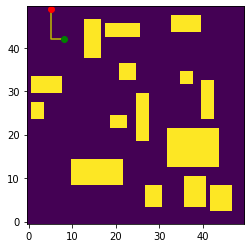

Number of steps taken in A* Path,  11
[0.0, 3.0, -1.0, 2.0, 1.0, -3.0]
[(1.0, 0.0), (6.123233995736766e-17, -1.0), (6.123233995736766e-17, -1.0), (-1.0, 1.2246467991473532e-16), (6.123233995736766e-17, 1.0), (6.123233995736766e-17, 1.0)]
[0.0, 3.0, -1.0, 2.0, 1.0, -3.0]
[(1.0, 0.0), (6.123233995736766e-17, -1.0), (6.123233995736766e-17, -1.0), (-1.0, 1.2246467991473532e-16), (6.123233995736766e-17, 1.0), (6.123233995736766e-17, 1.0)]
[0.0, 3.0, -1.0, 2.0, 1.0, -3.0]
[(1.0, 0.0), (6.123233995736766e-17, -1.0), (6.123233995736766e-17, -1.0), (-1.0, 1.2246467991473532e-16), (6.123233995736766e-17, 1.0), (6.123233995736766e-17, 1.0)]
[-1.0, 0.0, 2.0, 3.0, 1.0, -3.0]
[(6.123233995736766e-17, -1.0), (1.0, 0.0), (-1.0, 1.2246467991473532e-16), (6.123233995736766e-17, -1.0), (6.123233995736766e-17, 1.0), (6.123233995736766e-17, 1.0)]
[0.0, 1.0, 3.0, 2.0, -3.0, -1.0]
[(-1.8369701987210297e-16, -1.0), (1.0, -2.4492935982947064e-16), (-1.0, 1.2246467991473532e-16), (3.061616997868383e-16, 1.0), (

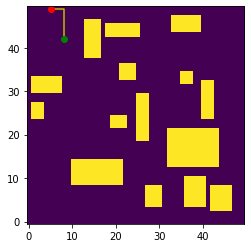

Number of steps taken in pred Path 11


In [64]:
# Test
pred_len = []
astar_len = []
n_test = 0
map_size = (50,50)

if n_test < 1:
    # TODO: Generalize to any map shape
    start = (random.randint(1,49), random.randint(1,49))
    goal = (random.randint(1,49), random.randint(1,49))
#     arr, test_MAP = placeRandomRooms(map_size, minRoomSize=3, maxRoomSize=15, roomStep = 1, margin = 1, attempts = 100)
    # If path is available, get test info
    try:
#         start, goal = (28, 14), (26, 37)
        arr, test_MAP = MAPS[0][1], MAPS[0][0]
        pred_path = test_on_new_map(test_MAP, arr, start, goal, clf, polar=False)
        OccupancyGridMap(arr, 1).plot()
        plot_path(pred_path)
        pred_len.append(len(pred_path))
        print('Number of steps taken in pred Path', len(pred_path))
        astar_len.append(len(get_path(start, goal, arr, False)))
        n_test += 1
    except:
        # No path found
#         continue
        pass

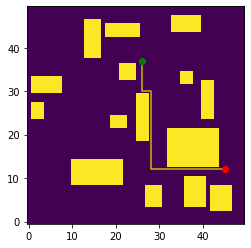

[(45, 12),
 (44, 12),
 (43, 12),
 (42, 12),
 (41, 12),
 (40, 12),
 (39, 12),
 (38, 12),
 (37, 12),
 (36, 12),
 (35, 12),
 (34, 12),
 (33, 12),
 (32, 12),
 (31, 12),
 (30, 12),
 (29, 12),
 (28, 12),
 (28, 13),
 (28, 14),
 (28, 15),
 (28, 16),
 (28, 17),
 (28, 18),
 (28, 19),
 (28, 20),
 (28, 21),
 (28, 22),
 (28, 23),
 (28, 24),
 (28, 25),
 (28, 26),
 (28, 27),
 (28, 28),
 (28, 29),
 (28, 30),
 (27, 30),
 (26, 30),
 (26, 31),
 (26, 32),
 (26, 33),
 (26, 34),
 (26, 35),
 (26, 36),
 (26, 37)]

In [58]:
get_path((45, 12), (26, 37), MAPS[0][1], plot = True)

In [26]:
df_

,0,1,2,3,4,5,6,7,8,9,10
0,6.5,2.121320,1.5,2.121320,30.5,4.949747,3.5,4.949747,-1.000000e+00,3.600000e+01,1.0
1,0.5,0.707107,11.5,6.363961,4.5,6.363961,6.5,0.707107,3.500000e+01,1.000000e+00,-1.0
2,5.5,0.707107,0.5,0.707107,12.5,6.363961,4.5,6.363961,-2.000000e+00,3.500000e+01,0.0
3,4.5,0.707107,0.5,0.707107,13.5,6.363961,4.5,6.363961,-3.000000e+00,3.500000e+01,0.0
4,3.5,23.334524,0.5,0.707107,14.5,6.363961,4.5,6.363961,-4.000000e+00,3.500000e+01,0.0
5,2.5,21.920310,9.5,0.707107,15.5,6.363961,4.5,3.535534,-5.000000e+00,3.500000e+01,1.0
6,8.5,0.707107,0.5,0.707107,5.5,3.535534,15.5,21.920310,3.400000e+01,5.000000e+00,0.0
7,7.5,0.707107,0.5,0.707107,6.5,3.535534,15.5,21.920310,3.300000e+01,5.000000e+00,0.0
8,6.5,0.707107,0.5,0.707107,7.5,3.535534,15.5,21.920310,3.200000e+01,5.000000e+00,0.0
9,5.5,13.435029,34.5,0.707107,8.5,4.949747,15.5,21.920310,3.100000e+01,5.000000e+00,1.0


In [245]:
def plot_path_with_lines(pred_path, MAP):
    '''
    Given predicted path nodes and map, 
    plot the path and the sensor readings for each node
    '''
    # Update node positions for shapely plotting
    pred_path = [(p[0]+0.5, p[1]+0.5) for p in pred_path]
    # Save filenames for GIF creation
    filenames=[]
    for i, node in enumerate(pred_path):
        # Create fig
        fig = plt.figure(frameon=False)
        fig.set_size_inches(6,6)
        plt.plot(*LineString(pred_path).xy)
        plt.scatter(*node, s=30, alpha=1.0)
        # Get lines from sensor 
        _, lines = synthetic_sensor(MAP, node)
        for index, l in enumerate(MAP): 
            if index != 0:
                plt.fill(*l.xy, alpha=1)
            else:
                plt.plot(*l.xy, alpha=1)
        for k, line in enumerate(lines):
            plt.plot(*line.xy, alpha=0.25)
        filenames.append('img_{}.png'.format(i))
        plt.savefig('img_{}.png'.format(i))
        plt.close()
    
    # Make GIF
    images = []
    for filename in filenames:
        images.append(imageio.imread(filename))
    imageio.mimsave('demo.gif', images)
        
plot_path_with_lines(pred_path, test_MAP)

In [244]:
# DL Solution ... not currently learning. 

import torch
class SensorData(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df.copy()
        self.mms = MinMaxScaler()
        self.mms.fit(df.drop('out', axis=1).values)
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        sample = self.df.iloc[idx]
        x = self.mms.transform(sample.drop('out').values.astype(np.float32).reshape(1,-1))
        y = sample['out']
        return (torch.from_numpy(x).double(), y)
    
ds = SensorData(df)
train_loader = torch.utils.data.DataLoader(ds,64,True, num_workers=0, pin_memory=True)

from resnet1d import ResNet1D
model = ResNet1D(1,64,3,3,1,24,4).cuda()

from tqdm.notebook import tqdm
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

loss = 0
for i in range(20):
    ep_loss = 0
    for batch in tqdm(train_loader):
        model.train()
        x,y = batch[0].cuda().float(), batch[1].cuda()

        optimizer.zero_grad()
        
        out = model(x)
        loss = criterion(out,y.long())
        loss.backward()
        optimizer.step()
        ep_loss += loss.item()
        
    print(ep_loss/len(train_loader))
        

NameError: name 'nn' is not defined

In [2]:
!pip install imageio

     |████████████████████████████████| 3.3 MB 8.3 MB/s eta 0:00:01
